## Basic Time Series Modelling 

Going through modelling process for:
* AR
* MA
* ARMA
* ARIMA

Following (approx.) the Box-Jenkins methodology: (1) selecting models. (2) selecting order. (3) fitting parameters. (4) examining fit. (5) forecasting with prediction intervals. 

In [35]:
import numpy as np
import pandas as pd
import pandas_datareader
from matplotlib import pyplot as plt
from numpy.linalg import inv

%config InlineBackend.figure_format = 'retina'
plt.style.use(['science', 'notebook', 'grid'])

### 1. AR(p)

In [2]:
df = pd.read_csv('data/sealevel.csv')
df.head()

,Altimeter type,Merged file cycle nr,Year,Nr observations,Weighted nr observations,GMSL,GMSL std,GMSL smooth,GIA,GIA std,GIA smooth,GIA smooth cycle removed
0,0.0,11.0,1993.011526,466462.0,337277.00,-37.24,92.66,-37.02,-37.24,92.66,-37.02,-37.55
1,0.0,12.0,1993.038692,460889.0,334037.31,-40.35,95.39,-38.20,-40.34,95.39,-38.19,-38.06
2,0.0,13.0,1993.065858,472123.0,342416.09,-40.17,92.29,-38.28,-40.16,92.29,-38.27,-37.60
3,0.0,14.0,1993.093025,421377.0,306050.59,-41.92,96.20,-38.56,-41.89,96.19,-38.54,-37.45
4,0.0,15.0,1993.120191,459548.0,331094.09,-36.89,94.64,-37.87,-36.85,94.63,-37.83,-36.44


In [3]:
df.set_index("Year", inplace=True)
df = df[["GMSL"]]
df.head()

,GMSL
Year,
1993.011526,-37.24
1993.038692,-40.35
1993.065858,-40.17
1993.093025,-41.92
1993.120191,-36.89


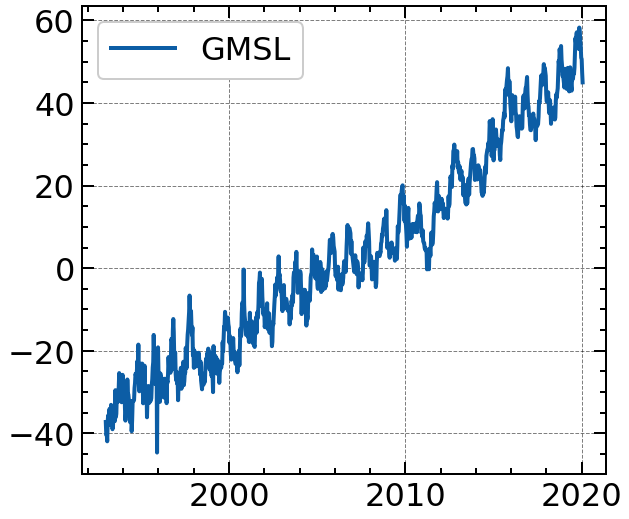

In [23]:
fig, ax = plt.subplots()
ax.plot(df.index, df["GMSL"])
ax.legend(["GMSL"])
fig.set_size_inches(4.7, 4.3)
plt.show()

Detring by assuming a linear trend. This is fitted by a linear regression model: $Y_t = \beta_0 + \beta_1 t + Z_t$, $Z \overset{\text{iid}}{\sim} N(0, \sigma^2)$. Writing the model as $\mathbf{Y} = \mathbf{X\beta} + \mathbf{Z}$ we solve the normal equations to obtain the approriate solution (can be solved with QR decomposition for increased numerical stability). Thus $\hat{\mathbf{\beta}}_{\text{OLS}} = (\mathbf{X}^{\text{T}}\mathbf{X})^{-1}\mathbf{X}^{\text{T}}\mathbf{Y}$.

In [44]:
number_of_observations = len(df)
Y = np.array(df["GMSL"])
X = np.stack([np.ones(number_of_observations), np.array(df.index)]).T
beta = inv((X.T @ X)) @ X.T @ Y

In [46]:
def trend(t: np.array, beta: np.array = beta) -> np.array:
    n = len(t)
    H = np.stack([np.ones(n), t]).T
    return H @ beta

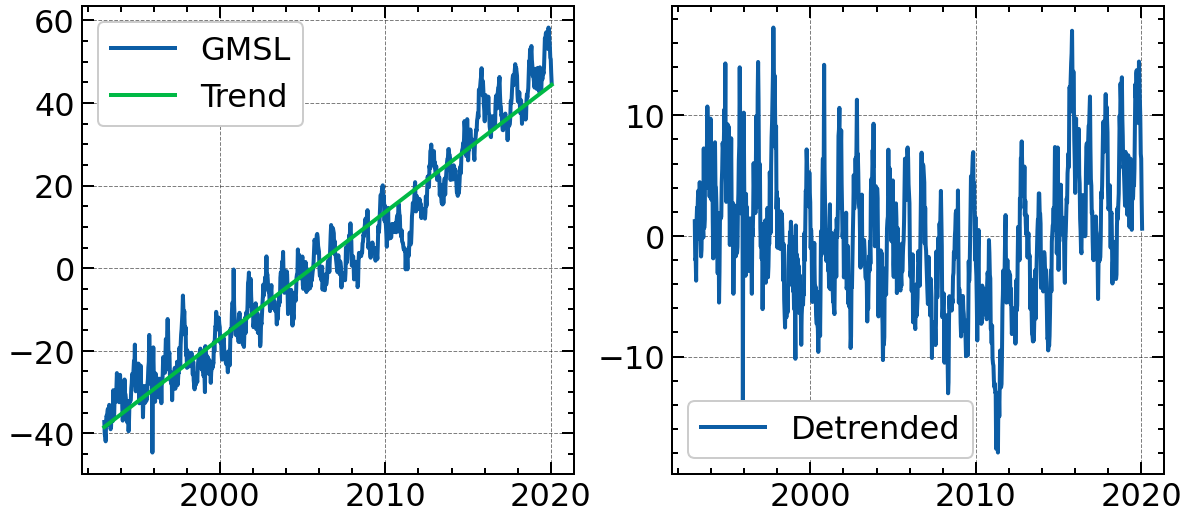

In [72]:
fig, ax = plt.subplots(1,2)
ax[0].plot(df.index, df["GMSL"])
ax[0].plot(df.index, trend(df.index))
ax[0].legend(["GMSL", "Trend"])
ax[1].plot(df.index, df["GMSL"]-trend(df.index))
ax[1].legend(["Detrended"])
fig.set_size_inches(9.7, 4.3)
plt.show()

In [76]:
df_training = (df["GMSL"]-trend(df.index)).iloc[:700]
df_validation = (df["GMSL"]-trend(df.index)).iloc[700:]

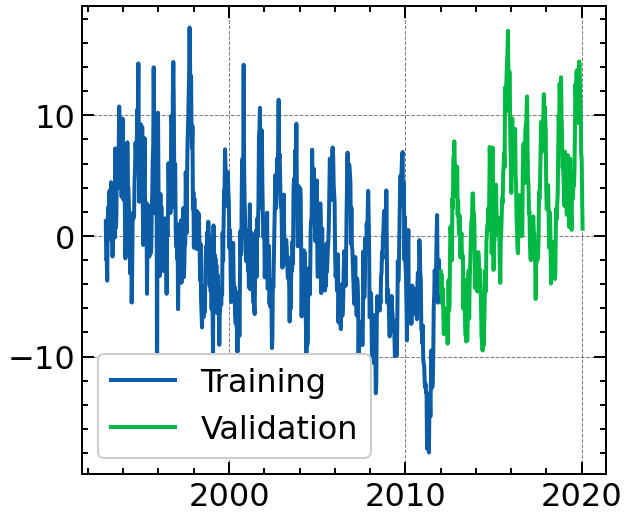

In [79]:
fig, ax = plt.subplots()
ax.plot(df.index[:700], df_training)
ax.plot(df.index[700:], df_validation)
ax.legend(["Training", "Validation"])
fig.set_size_inches(4.7, 4.3)
plt.show()

In [236]:
def fit_ar_model(data: np.array, lag: int) -> np.array:
    number_of_observations = len(data)
    if lag > number_of_observations:
        raise ValueError
    
    # build Y matrix.
    Y = data[lag:]

    # build X matrix.
    X = []
    for i in range(lag):
        X.append(data[lag-i-1:number_of_observations-i-1])
    X = np.stack(X).T
    
    # solve normal equations.
    phi = inv(X.T @ X) @ X.T @ Y
    return phi       

In [237]:
phi = fit_ar_model(data=np.array(df_training), lag=10)
phi

array([ 0.62156052,  0.10763277,  0.15104657,  0.1745703 , -0.02184709,
       -0.05955406, -0.09578106,  0.07585221, -0.11175939,  0.02305208])

In [255]:
def step_prediction(phi: np.array, data: np.array) -> np.array:
    lag = len(phi)
    number_of_observations = len(data)
    X = []
    for i in range(lag):
        X.append(data[lag-i:number_of_observations-i])
    X = np.stack(X).T
    return X @ phi

In [267]:
one_step_predictions = step_prediction(phi, np.array(df_training))

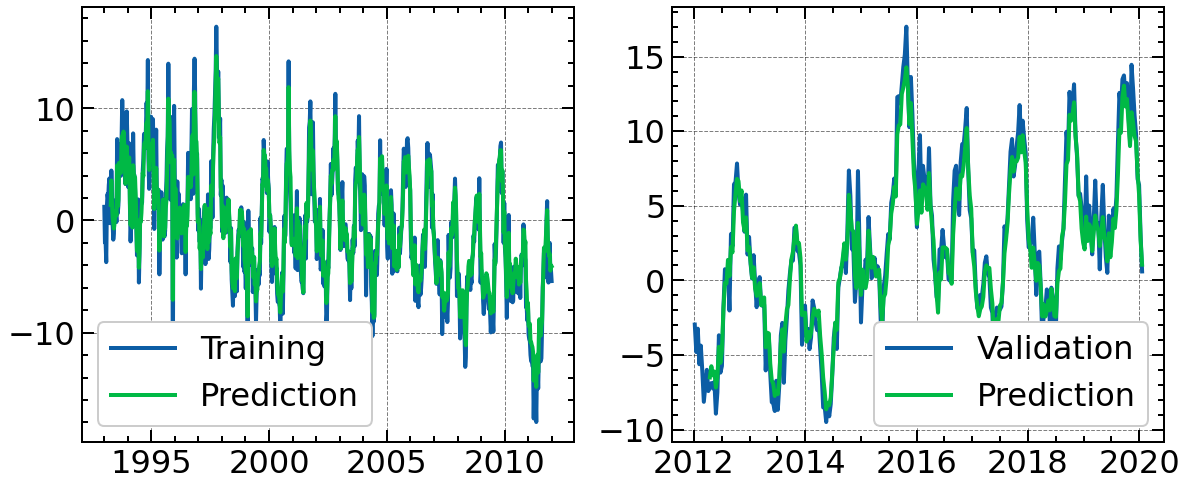

In [268]:
fig, ax = plt.subplots(1,2)
ax[0].plot(df.index[:700], np.array(df_training))
ax[0].plot(df.index[10:700], one_step_predictions)
ax[0].legend(["Training", "Prediction"])

ax[1].plot(df.index[700:], np.array(df_validation))
ax[1].plot(df.index[710:], np.array(step_prediction(phi, np.array(df_validation))))
ax[1].legend(["Validation", "Prediction"])
fig.set_size_inches(9.7, 4,3)
plt.show()

Checking the residuals w.r.t the training data. Assuming our model is correct, the residuals should resemble Gaussian WN.

### 2. MA(q)

### 3. ARMA(p, q)

### 4. ARIMA(p, d, q)